# Fitting is an Art!

Python macro for testing which fitting procedure is likely to give the "best" results.

In this case, we consider **Gaussian distributions on constant background (peak fitting and searching)**, where the fit precision and hypothesis testing can be improved by sharing common parameters.

### Authors:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

In [208]:
r = np.random
r.seed(42)
SavePlots = False

## CASE: Gaussian distributions on a constant background:

The initial fitting function is the following:

* $f_{1}(x) = \text{Gauss + Constant} =  \frac{N_{sig}}{\sigma\sqrt(2\pi)}\cdot \exp \left[-0.5 \cdot\left(\frac{(x-\mu)}{\sigma}\right)^{2} \right] + C~~~$ for $x$ in $[-\infty,\infty]$

It disregards that there are additional signal peaks at higher values. Your job is to expand the fit until it really describes the data.

In [209]:
# Signal parameters:
Npoints_gauss = 2000
fN     = 0.5
mux    = 1.43
dmux   = 1.41
sigmax = 0.15          

# Background parameters:
Npoints_pol0 = 5000

# Binning parameters:
xmin   =  0.0
xmax   = 10.0
Nbins  =  200
binwidth_gauss = (xmax-xmin) / float(Nbins)
print(f"  The bin width is: {binwidth_gauss:5.2f}")

  The bin width is:  0.05


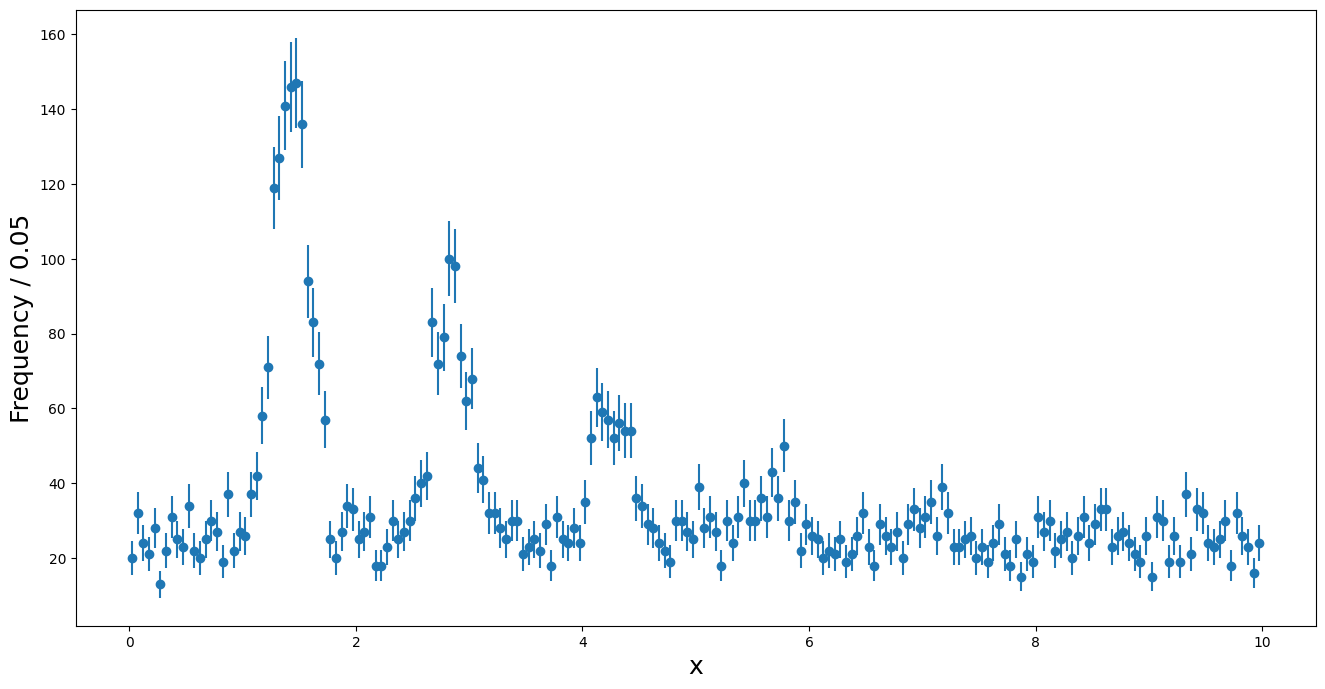

In [210]:
# Fill histogram with signal and background events:
Npeak = np.random.geometric(fN, Npoints_gauss)                  # Make random assignment to Gaussian peaks
sig = np.random.normal(loc=mux+dmux*(Npeak-1), scale=sigmax)    # Now generate signal according to these peaks
bkg = np.random.uniform(xmin, xmax, size=Npoints_pol0)

data = np.concatenate([sig, bkg])
counts, bin_edges = np.histogram(data, bins=Nbins, range=(xmin, xmax))
unc_count = np.sqrt(counts)
x = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, counts, yerr=unc_count, marker = 'o', ls='')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('Frequency / 0.05', fontsize=18);

### Define function (including bin width to get normalisation right):


In [211]:
def func_gpol0(x, N, mu, sigma, cst) :
    norm = binwidth_gauss * N / np.sqrt(2.0*np.pi) / sigma
    z = (x-mu)/sigma
    return norm * np.exp(-0.5*z*z)  +  cst
def func_expanded(x, N1,N2,N3,mu1,sigma1,mu2,sigma2,mu3,sigma3,cst) :
    norm1 = binwidth_gauss * N1 / np.sqrt(2.0*np.pi) / sigma1 
    norm2 = binwidth_gauss * N2 / np.sqrt(2.0*np.pi) / sigma2 
    norm3 = binwidth_gauss * N3 / np.sqrt(2.0*np.pi) / sigma3 
    z1 = (x-mu1)/sigma1
    z2 = (x-mu2)/sigma2
    z3 = (x-mu3)/sigma3
    return norm1 * np.exp(-0.5*z1*z1) + norm2 * np.exp(-0.5*z2*z2) + norm3 * np.exp(-0.5*z3*z3) + cst
def func_samesigma(x, N1,N2,N3,mu1,mu2,mu3,sigma,cst) :
    norm1 = binwidth_gauss * N1 / np.sqrt(2.0*np.pi) / sigma 
    norm2 = binwidth_gauss * N2 / np.sqrt(2.0*np.pi) / sigma 
    norm3 = binwidth_gauss * N3 / np.sqrt(2.0*np.pi) / sigma 
    z1 = (x-mu1)/sigma
    z2 = (x-mu2)/sigma
    z3 = (x-mu3)/sigma
    return norm1 * np.exp(-0.5*z1*z1) + norm2 * np.exp(-0.5*z2*z2) + norm3 * np.exp(-0.5*z3*z3) + cst

In [212]:
mask = counts>0
cfit = cost.LeastSquares(x[mask], counts[mask], unc_count[mask], func_expanded)
cfit2 = cost.LeastSquares(x[mask], counts[mask], unc_count[mask], func_gpol0)
cfit3 = cost.LeastSquares(x[mask], counts[mask], unc_count[mask], func_samesigma)

mfit2 = Minuit(cfit2, N=150, mu=1.5, sigma=.5, cst=20.0)
mfit = Minuit(cfit, N1=150, mu1=1.5, sigma1=.5, N2=100, mu2=2.9, sigma2=.5, N3=130, mu3=4.2, sigma3=.5, cst=20)
mfit3 = Minuit(cfit3, N1=150,N2=100, N3=130, mu1=1.5, mu2=2.9, mu3=4.2, sigma=.5, cst=20)
mfit.migrad()
mfit2.migrad()
mfit3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 232.3 (χ²/ndof = 1.2)      │              Nfcn = 306              │
│ EDM = 1.86e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N1    │    980    │    40     │            │            │         │         │       │
│ 1 │ N2    │    521    │    30     │            │            │         │         │       │
│ 2 │ N3    │    284    │    25     │            │            │         │         │       │
│ 3 │ mu1   │   1.427   │   0.007   │            │            │         │         │       │
│ 4 │ mu2   │   2.840   │   0.011   │            │            │         │         │       │
│ 5 │ mu3   │   4.255   │   0.017   │            │            │         │         │       │
│ 6 │ sigma │   0.155   │   0.005   │            │            │         │         │       │
│ 7 │ cst   │   24.8    │    0.4    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │        N1        N2        N3       mu1       mu2       mu3     sigma       cst │
├───────┼─────────────────────────────────────────────────────────────────────────────────┤
│    N1 │  1.44e+03     0.1e3     0.1e3   0.31e-3   3.82e-3   7.53e-3 43.647e-3     -3.07 │
│    N2 │     0.1e3       910     0.1e3  -0.25e-3   0.82e-3   5.61e-3 32.986e-3     -2.68 │
│    N3 │     0.1e3     0.1e3       631  -0.15e-3   1.90e-3  -2.23e-3 22.453e-3     -2.36 │
│   mu1 │   0.31e-3  -0.25e-3  -0.15e-3  4.43e-05        -0        -0        -0         0 │
│   mu2 │   3.82e-3   0.82e-3   1.90e-3        -0  0.000114         0  0.002e-3  -0.03e-3 │
│   mu3 │   7.53e-3   5.61e-3  -2.23e-3        -0         0   0.00029  0.004e-3  -0.06e-3 │
│ sigma │ 43.647e-3 32.986e-3 22.453e-3        -0  0.002e-3  0.004e-3  2.24e-05 -0.495e-3 │
│   cst │     -3.07     -2.68     -2.36         0  -0.03e-3  -0.06e-3 -0.495e-3     0.164 │
└───────┴─────────────────────────────────────────────────────────────────────────────────┘

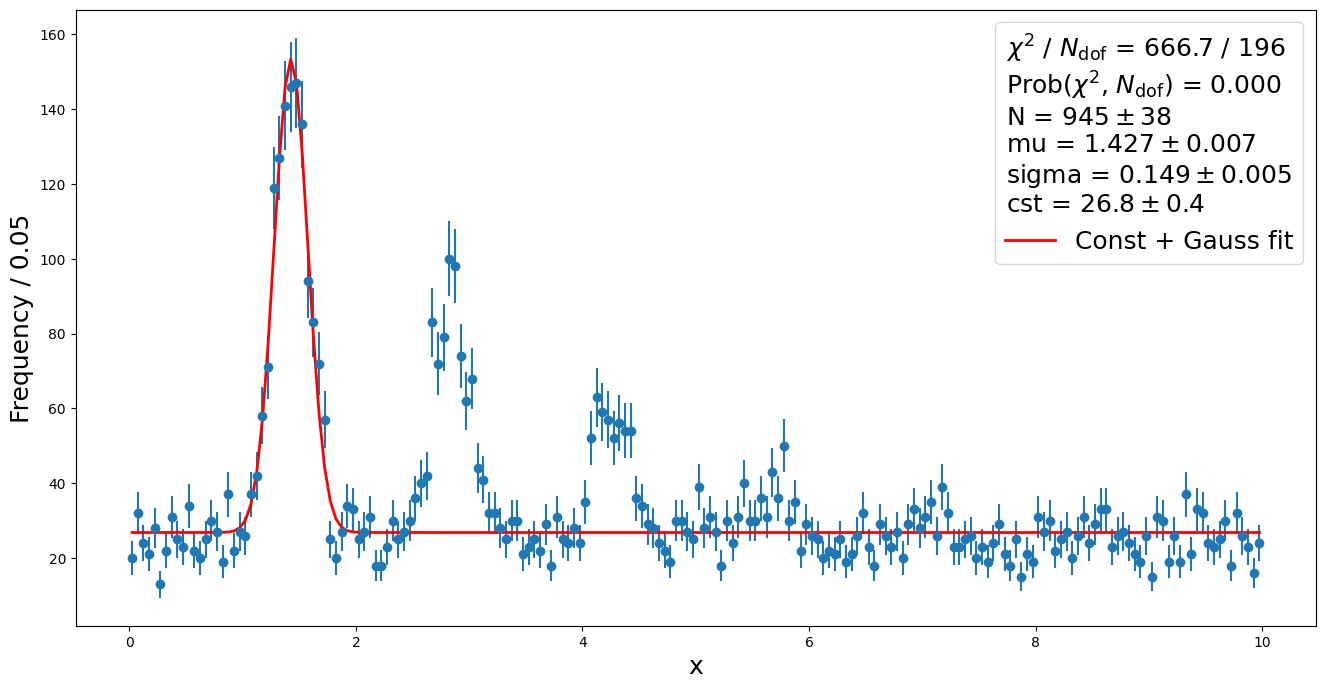

In [213]:
if (not mfit.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

ax.plot(x, func_gpol0(x, *mfit2.values[:]), 'r', linewidth=2.0, label='Const + Gauss fit')

# Adding fit results to plot:
chi2_2 = mfit2.fval                     # ChiSquare value
Ndof = len(x[mask]) - mfit2.nfit      # Number of (non-empty) bins
Prob = stats.chi2.sf(chi2_2, Ndof)     # ChiSquare probability given Ndof

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {chi2_2:.1f} / {Ndof}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
for p, v, e in zip(mfit2.parameters, mfit2.values[:], mfit2.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")

ax.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
fig

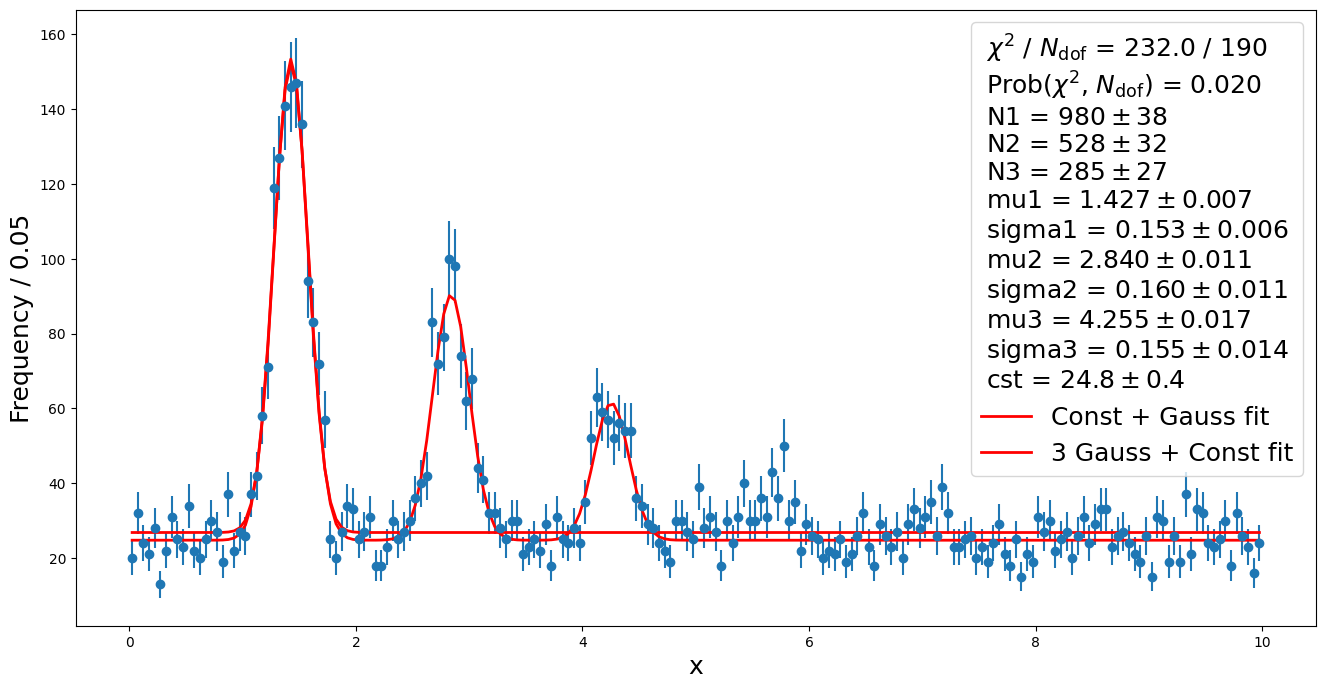

In [214]:
if (not mfit.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

# ax.plot(x, func_gpol0(x, *mfit.values[:]), 'r', linewidth=2.0, label='Const + Gauss fit')
ax.plot(x, func_expanded(x, *mfit.values[:]), 'r', linewidth=2.0, label='3 Gauss + Const fit')


# Adding fit results to plot:
chi2 = mfit.fval                     # ChiSquare value
Ndof = len(x[mask]) - mfit.nfit      # Number of (non-empty) bins
Prob = stats.chi2.sf(chi2, Ndof)     # ChiSquare probability given Ndof

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
for p, v, e in zip(mfit.parameters, mfit.values[:], mfit.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")

ax.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
fig

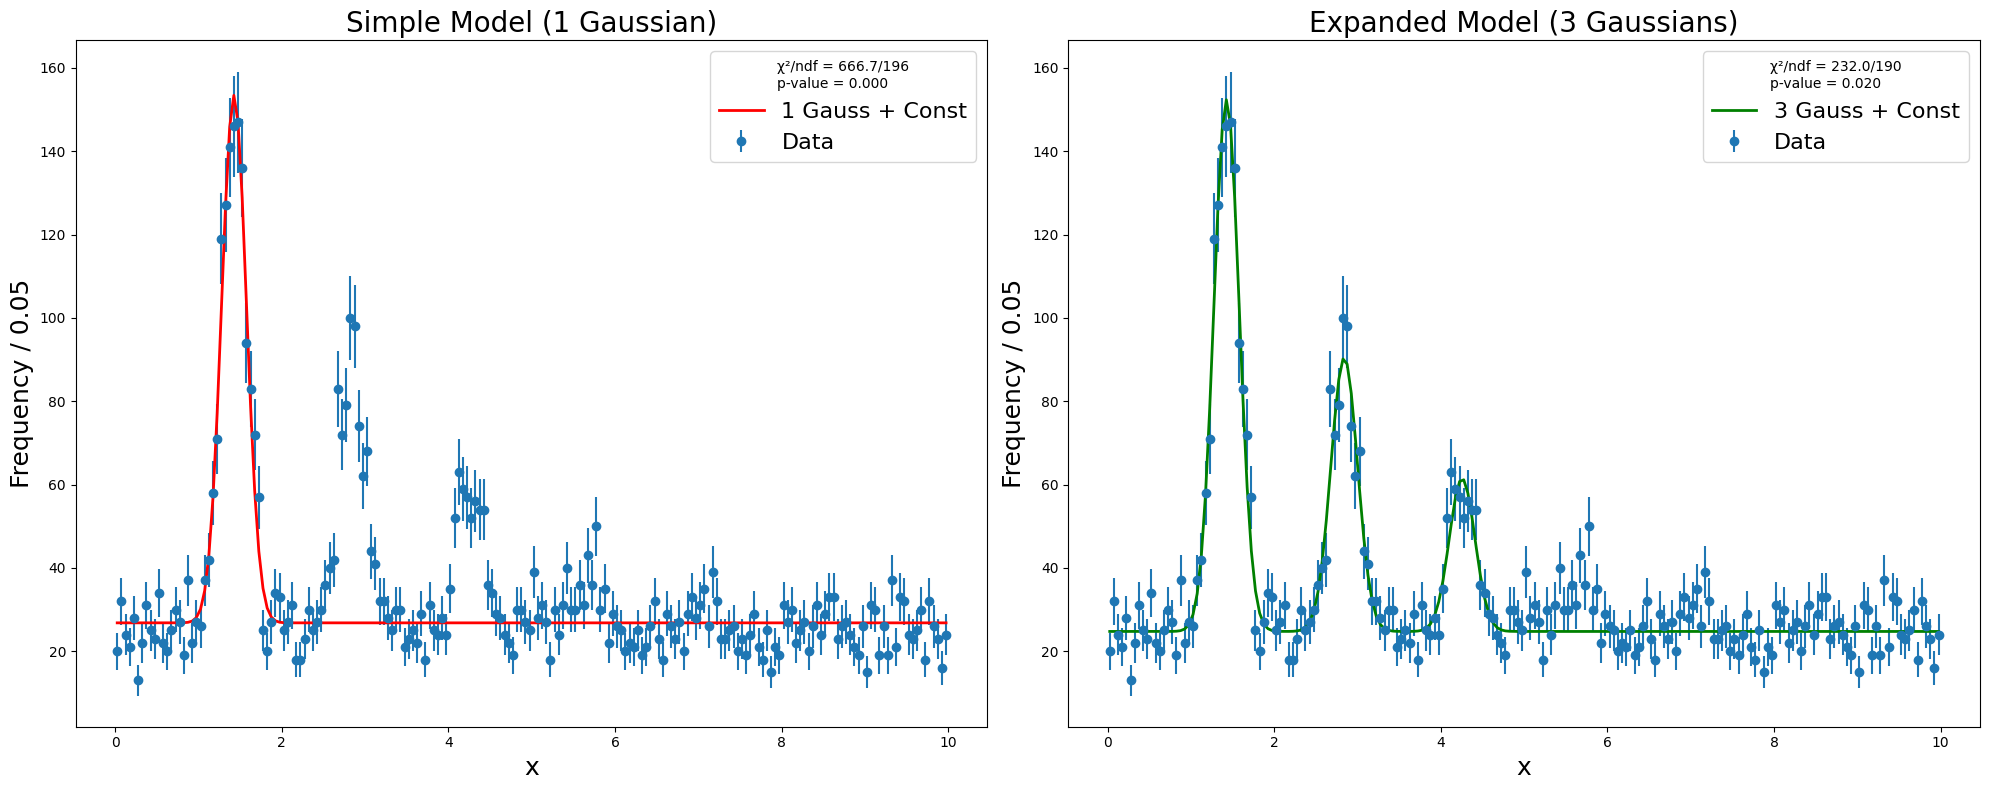


QUESTION 2 ANALYSIS

[1] PEAK SIGNIFICANCE:
  Peak 1: N = 979.9 ± 38.2 → 25.7σ significance
  Peak 2: N = 527.5 ± 32.1 → 16.4σ significance
  Peak 3: N = 284.8 ± 26.9 → 10.6σ significance


In [215]:
# Create a fresh figure for comparison
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# === LEFT PLOT: Simple 1-Gauss Model ===
ax1.errorbar(x, counts, yerr=unc_count, marker='o', ls='', label='Data')
ax1.plot(x, func_gpol0(x, *mfit2.values[:]), 'r-', linewidth=2, label='1 Gauss + Const')
ax1.set_xlabel('x', fontsize=18)
ax1.set_ylabel('Frequency / 0.05', fontsize=18)
ax1.set_title('Simple Model (1 Gaussian)', fontsize=20)

chi2_simple = mfit2.fval
Ndof_simple = len(x[mask]) - mfit2.nfit
Prob_simple = stats.chi2.sf(chi2_simple, Ndof_simple)

fit_info_simple = [
    f"χ²/ndf = {chi2_simple:.1f}/{Ndof_simple}",
    f"p-value = {Prob_simple:.3f}"
]
ax1.legend(title="\n".join(fit_info_simple), fontsize=16)

# === RIGHT PLOT: Expanded 3-Gauss Model ===
ax2.errorbar(x, counts, yerr=unc_count, marker='o', ls='', label='Data')
ax2.plot(x, func_expanded(x, *mfit.values[:]), 'g-', linewidth=2, label='3 Gauss + Const')
ax2.set_xlabel('x', fontsize=18)
ax2.set_ylabel('Frequency / 0.05', fontsize=18)
ax2.set_title('Expanded Model (3 Gaussians)', fontsize=20)

chi2_expanded = mfit.fval
Ndof_expanded = len(x[mask]) - mfit.nfit
Prob_expanded = stats.chi2.sf(chi2_expanded, Ndof_expanded)

fit_info_expanded = [
    f"χ²/ndf = {chi2_expanded:.1f}/{Ndof_expanded}",
    f"p-value = {Prob_expanded:.3f}"
]
ax2.legend(title="\n".join(fit_info_expanded), fontsize=16)

plt.tight_layout()
plt.show()

# === NOW ANSWER QUESTION 2 ===
print("\n" + "="*60)
print("QUESTION 2 ANALYSIS")
print("="*60)

# Part 1: Peak Significance
print("\n[1] PEAK SIGNIFICANCE:")
for i in [1, 2, 3]:
    N_val = mfit.values[f'N{i}']
    N_err = mfit.errors[f'N{i}']
    sig = N_val / N_err
    print(f"  Peak {i}: N = {N_val:.1f} ± {N_err:.1f} → {sig:.1f}σ significance")

In [216]:
# liklihood ratio test, wilks theorem
# Get χ² values from both fits
chi2_simple = mfit2.fval   # 1-Gaussian model
chi2_complex = mfit.fval   # 3-Gaussian model
print(f"\n  Chi2 Simple Model: {chi2_simple:.1f}")
print(f"  Chi2 Complex Model: {chi2_complex:.1f}")

# Count parameters
npar_simple = mfit2.nfit   # Should be 4 (N, mu, sigma, cst)
npar_complex = mfit.nfit   # Should be 10 (N1,mu1,sig1, N2,mu2,sig2, N3,mu3,sig3, cst)
print(f"  Number of parameters Simple Model: {npar_simple}")
print(f"  Number of parameters Complex Model: {npar_complex}")


# Calculate test statistic
delta_chi2 = chi2_simple - chi2_complex
delta_npar = npar_complex - npar_simple

p_value = stats.chi2.sf(delta_chi2, delta_npar)



print(f"\n[2] LIKELIHOOD RATIO TEST:")
print(f"  Δχ² = {delta_chi2:.1f} with Δndf = {delta_npar} → p-value = {p_value:.3e}")   
print('they are nested as the simple is just the complex with N2 and N3 set to 0. Then use wilks theorem. We see that the complex model is strongly preferred.')



  Chi2 Simple Model: 666.7
  Chi2 Complex Model: 232.0
  Number of parameters Simple Model: 4
  Number of parameters Complex Model: 10

[2] LIKELIHOOD RATIO TEST:
  Δχ² = 434.7 with Δndf = 6 → p-value = 9.743e-91
they are nested as the simple is just the complex with N2 and N3 set to 0. Then use wilks theorem. We see that the complex model is strongly preferred.


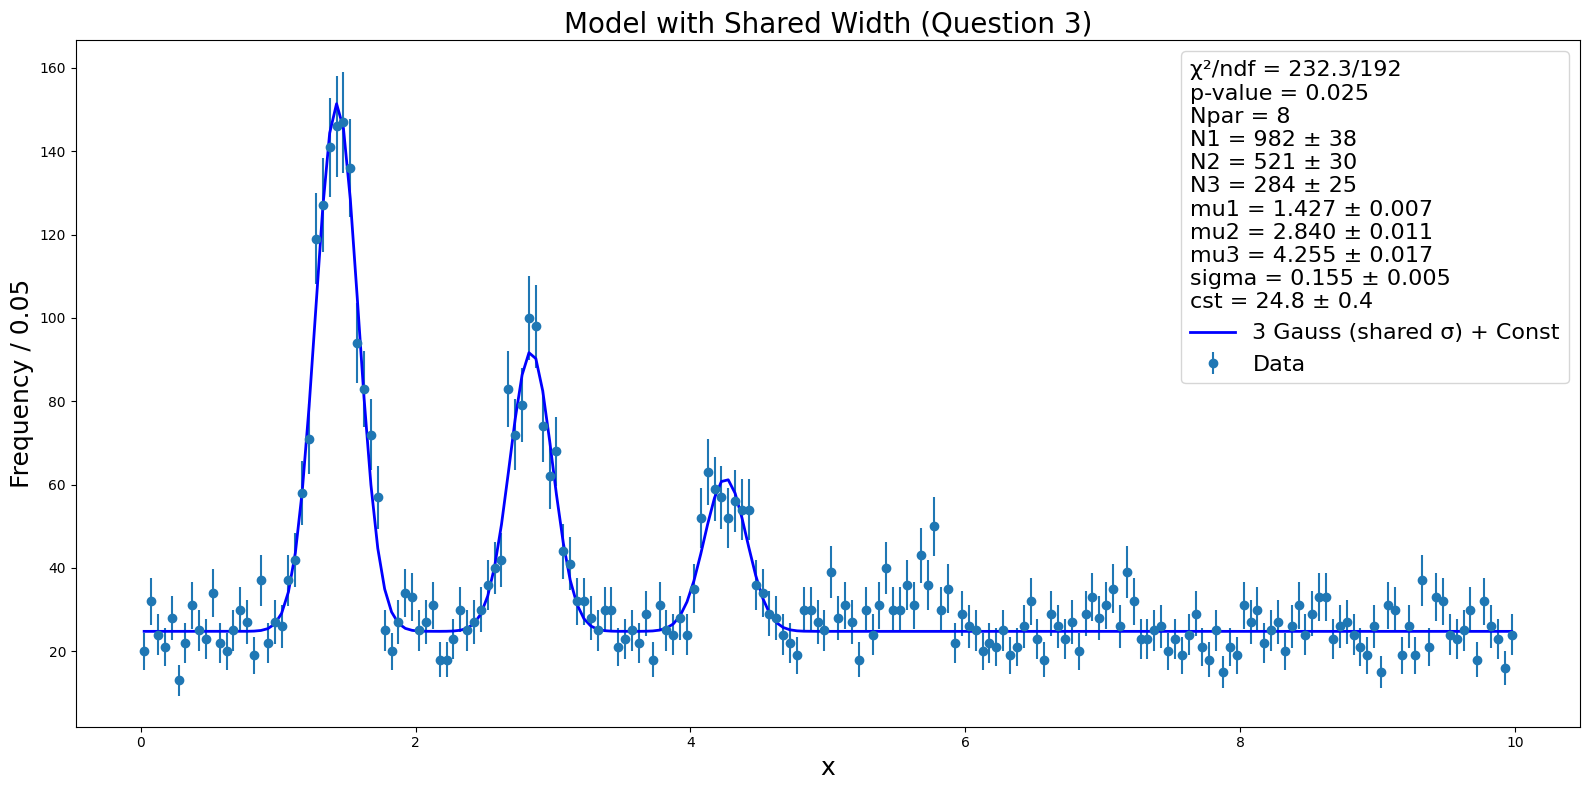


QUESTION 3: SHARED WIDTH MODEL
Number of parameters: 8 (reduced from 10)
Shared σ = 0.1548 ± 0.0047

[1] PEAK SIGNIFICANCE:
  Peak 1: N = 982.4 ± 37.9 → 25.9σ significance
  Peak 2: N = 521.2 ± 30.2 → 17.3σ significance
  Peak 3: N = 284.4 ± 25.1 → 11.3σ significance
slight increase in peak significances due to reduced uncertainties from fewer parameters.


In [219]:
# Create figure for shared sigma model
fig3, ax3 = plt.subplots(figsize=(16, 8))

# Plot data
ax3.errorbar(x, counts, yerr=unc_count, marker='o', ls='', label='Data')

# Plot the fit with shared sigma
ax3.plot(x, func_samesigma(x, *mfit3.values[:]), 'b-', linewidth=2, label='3 Gauss (shared σ) + Const')

ax3.set_xlabel('x', fontsize=18)
ax3.set_ylabel('Frequency / 0.05', fontsize=18)
ax3.set_title('Model with Shared Width (Question 3)', fontsize=20)

# Calculate fit statistics
chi2_shared = mfit3.fval
Ndof_shared = len(x[mask]) - mfit3.nfit
Prob_shared = stats.chi2.sf(chi2_shared, Ndof_shared)

# Create fit info
fit_info_shared = [
    f"χ²/ndf = {chi2_shared:.1f}/{Ndof_shared}",
    f"p-value = {Prob_shared:.3f}",
    f"Npar = {mfit3.nfit}"
]

# Add parameter values
for p, v, e in zip(mfit3.parameters, mfit3.values[:], mfit3.errors[:]):
    Ndecimals = max(0, -np.int32(np.log10(e)-1-np.log10(2)))
    fit_info_shared.append(f"{p} = {v:.{Ndecimals}f} ± {e:.{Ndecimals}f}")

ax3.legend(title="\n".join(fit_info_shared), fontsize=16, title_fontsize=16, alignment='left', loc='upper right')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("QUESTION 3: SHARED WIDTH MODEL")
print("="*60)
print(f"Number of parameters: {mfit3.nfit} (reduced from {mfit.nfit})")
print(f"Shared σ = {mfit3.values['sigma']:.4f} ± {mfit3.errors['sigma']:.4f}")

print("\n[1] PEAK SIGNIFICANCE:")
for i in [1, 2, 3]:
    N_val = mfit3.values[f'N{i}']
    N_err = mfit3.errors[f'N{i}']
    sig = N_val / N_err
    print(f"  Peak {i}: N = {N_val:.1f} ± {N_err:.1f} → {sig:.1f}σ significance")

print('slight increase in peak significances due to reduced uncertainties from fewer parameters.')

# Questions:

 1. Look at the data plot and the corresponding fit. What type of fit is it? Does it
    run well (or at all)? And once it runs, does it seem to be reasonable? Why/why not?
    What is the p-value from the minimal Chi2 that your fit obtained, once you got any
    "reasonable" fit to work? Is it acceptable?
    Does the fitting function include all features of the data? Why/why not? Try for
    2-5 minutes and discuss it with others (or just think for yourself), before reading on!

    answer:Type: 1 Gaussian + constant background
   Does it run? Should converge if starting values are good
   Is it reasonable? NO - the p-value will be terrible because we're ignoring the other peaks at x ≈ 2.8, 4.2, 5.6, etc.
   The fit doesn't include all features (multiple peaks)

---
_2-5 minutes later_...

---

 2. As it happens, there seem to be a additional peaks. Try to write a new and
    expandeded fitting function, which includes these features in the model, and get the
    fit to run. How significant is the additional peak(s), based on significance of the
    amplitude? And what test would you apply to this, if you wanted to make a full-fledged
    hypothesis test between the two models? Are they nested? Can you actually get a number out?
    Again, discuss it before coding on.

---
_10-20 minutes later_...

---

 3. Imagine that you concluded that there were additional new peaks, and that you were sure that
    they had the same width as the original peak (for example because the width was due to
    the resolution of the apperatus, and not the peak itself). Does that help you in the fit,
    and if so, how? Does the significance of the peaks increase? Would it always do that?
    Also imagine, that the parameter of interest is the distance between the peaks. How
    would you now write your fitting function?

 4. How would you test, if the peaks are really equidistant? Do so...

 5. Assuming the peaks to be equidistant, how would you test, if the peaks are consistent with an unobserved peak at exactly zero? Do so...

 6. If one wanted to test the G+pol0 vs. the N*G+pol0 models against each other, which might be relevant, then considering the difference in ChiSquare values or -2ln of the likelihood ratio would be obvious (these two gives the same result, when errors are Gaussian and the binning does not have any effect). Wilk's theorem would provide the way to produce a p-value, thus doing a proper hypothesis test using the likelihood ratio test:

* Using iminuit, fit the data with both hypothesis, and note the Chi2 or LLH value (using `mfit.fval`).
* Then compute the test statistic $\chi^2_{1} - \chi^2_{2}$ or $-2\log{\frac{LH_{1}}{LH_{2}}}$, and see that it is $\chi^{2}$ distributed (Wilk's Theorem) from repeating many experiments.

NOTE: The test statistic distribution will depend on how many peaks you fit and if you (smartly) eliminated one parameter from the second fit.

# Learning points:

This exercise in "fitting tricks" should teach you that:
1. __Good starting values is paramount!__ (Almost all fits fail with poor starting values).
2. The form of the fitting function is also important.<br>
   a. Ensure that the x-values do not represent some small range far from 0.<br>
   b. Ensure that you give the fitting function enough freedom to fit the data.<br>
   c. Conversely, try to curb the number of parameters, if there are arguments for doing so (calibration peaks).<br>
   d. Make sure that you've normalised your fitting PDFs, to avoid correlations between normalisation and parameters.
3. If a fit continues to fail, try simply to draw the function and starting values on top of the data. Often, they don't match well (general advice, not just in this exercise).